# Applying K means ,Agglomerative DBSCAN, clustering algorithms on Donors Choose dataset

# DonorsChoose

<p>
DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.
</p>
<p>
    Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve:
<ul>
<li>
    How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible</li>
    <li>How to increase the consistency of project vetting across different volunteers to improve the experience for teachers</li>
    <li>How to focus volunteer time on the applications that need the most assistance</li>
    </ul>
</p>    
<p>
The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.
</p>

## About the DonorsChoose Data Set

The `train.csv` data set provided by DonorsChoose contains the following features:

Feature | Description 
----------|---------------
**`project_id`** | A unique identifier for the proposed project. **Example:** `p036502`   
**`project_title`**    | Title of the project. **Examples:**<br><ul><li><code>Art Will Make You Happy!</code></li><li><code>First Grade Fun</code></li></ul> 
**`project_grade_category`** | Grade level of students for which the project is targeted. One of the following enumerated values: <br/><ul><li><code>Grades PreK-2</code></li><li><code>Grades 3-5</code></li><li><code>Grades 6-8</code></li><li><code>Grades 9-12</code></li></ul>  
 **`project_subject_categories`** | One or more (comma-separated) subject categories for the project from the following enumerated list of values:  <br/><ul><li><code>Applied Learning</code></li><li><code>Care &amp; Hunger</code></li><li><code>Health &amp; Sports</code></li><li><code>History &amp; Civics</code></li><li><code>Literacy &amp; Language</code></li><li><code>Math &amp; Science</code></li><li><code>Music &amp; The Arts</code></li><li><code>Special Needs</code></li><li><code>Warmth</code></li></ul><br/> **Examples:** <br/><ul><li><code>Music &amp; The Arts</code></li><li><code>Literacy &amp; Language, Math &amp; Science</code></li>  
  **`school_state`** | State where school is located ([Two-letter U.S. postal code](https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations#Postal_codes)). **Example:** `WY`
**`project_subject_subcategories`** | One or more (comma-separated) subject subcategories for the project. **Examples:** <br/><ul><li><code>Literacy</code></li><li><code>Literature &amp; Writing, Social Sciences</code></li></ul> 
**`project_resource_summary`** | An explanation of the resources needed for the project. **Example:** <br/><ul><li><code>My students need hands on literacy materials to manage sensory needs!</code</li></ul> 
**`project_essay_1`**    | First application essay<sup>*</sup>  
**`project_essay_2`**    | Second application essay<sup>*</sup> 
**`project_essay_3`**    | Third application essay<sup>*</sup> 
**`project_essay_4`**    | Fourth application essay<sup>*</sup> 
**`project_submitted_datetime`** | Datetime when project application was submitted. **Example:** `2016-04-28 12:43:56.245`   
**`teacher_id`** | A unique identifier for the teacher of the proposed project. **Example:** `bdf8baa8fedef6bfeec7ae4ff1c15c56`  
**`teacher_prefix`** | Teacher's title. One of the following enumerated values: <br/><ul><li><code>nan</code></li><li><code>Dr.</code></li><li><code>Mr.</code></li><li><code>Mrs.</code></li><li><code>Ms.</code></li><li><code>Teacher.</code></li></ul>  
**`teacher_number_of_previously_posted_projects`** | Number of project applications previously submitted by the same teacher. **Example:** `2` 

<sup>*</sup> See the section <b>Notes on the Essay Data</b> for more details about these features.

Additionally, the `resources.csv` data set provides more data about the resources required for each project. Each line in this file represents a resource required by a project:

Feature | Description 
----------|---------------
**`id`** | A `project_id` value from the `train.csv` file.  **Example:** `p036502`   
**`description`** | Desciption of the resource. **Example:** `Tenor Saxophone Reeds, Box of 25`   
**`quantity`** | Quantity of the resource required. **Example:** `3`   
**`price`** | Price of the resource required. **Example:** `9.95`   

**Note:** Many projects require multiple resources. The `id` value corresponds to a `project_id` in train.csv, so you use it as a key to retrieve all resources needed for a project:

The data set contains the following label (the value you will attempt to predict):

Label | Description
----------|---------------
`project_is_approved` | A binary flag indicating whether DonorsChoose approved the project. A value of `0` indicates the project was not approved, and a value of `1` indicates the project was approved.

### Notes on the Essay Data

<ul>
Prior to May 17, 2016, the prompts for the essays were as follows:
<li>__project_essay_1:__ "Introduce us to your classroom"</li>
<li>__project_essay_2:__ "Tell us more about your students"</li>
<li>__project_essay_3:__ "Describe how your students will use the materials you're requesting"</li>
<li>__project_essay_3:__ "Close by sharing why your project will make a difference"</li>
</ul>


<ul>
Starting on May 17, 2016, the number of essays was reduced from 4 to 2, and the prompts for the first 2 essays were changed to the following:<br>
<li>__project_essay_1:__ "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."</li>
<li>__project_essay_2:__ "About your project: How will these materials make a difference in your students' learning and improve their school lives?"</li>
<br>For all projects with project_submitted_datetime of 2016-05-17 and later, the values of project_essay_3 and project_essay_4 will be NaN.
</ul>


In [2]:
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sqlite3
import string
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import word2vec
from gensim.models import keyedvectors

from tqdm import tqdm
import os
import pickle
import re
from nltk.corpus import stopwords

import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

### Reading Data

In [3]:
project_data = pd.read_csv('train_data.csv', nrows=30000)
resource_data = pd.read_csv('resources.csv', nrows=30000)
project_data.shape

(30000, 17)

In [4]:
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

          project_subject_categories     project_subject_subcategories  \
0                Literacy & Language                     ESL, Literacy   
1  History & Civics, Health & Sports  Civics & Government, Team Sports   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  
0                                             0                    0  
1                                             7                    1

In [5]:
resource_data.head(2)

id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   

    price  
0  149.00  
1   14.95

In [6]:
print(project_data.shape)
print(resource_data.shape)

(30000, 17)
(30000, 4)


In [7]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(2)

id   price  quantity
0  p000052  114.98         2
1  p000147   13.13        25

In [8]:
# join two dataframes in python: 
project_data = pd.merge(project_data, price_data, on='id', how='left')
project_data.shape

(30000, 19)

### preprocessing of project_subject_categories

In [9]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


### preprocessing of project_subject_subcategories

In [10]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

### Text preprocessing (Project_essay)

In [11]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [12]:
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  price  \
0                                             0                    0    NaN   
1                                             7                    1    NaN   

   quantity              clean_categories           clean_subcategories  \
0       NaN             Literacy_Language                  ESL Literacy   
1       NaN  History_Civics Health_Sports  Civics_Government TeamSports   

                                               essay  
0  My students are English learners that are work...  
1  Our students arrive to our school eager to lea...

In [13]:
# printing some random essays.
print(project_data['essay'].values[0])
print("="*50)
print(project_data['essay'].values[150])
print("="*50)
print(project_data['essay'].values[1000])
print("="*50)
print(project_data['essay'].values[2000])
print("="*50)
print(project_data['essay'].values[4999])
print("="*50)


My students are English learners that are working on English as their second or third languages. We are a melting pot of refugees, immigrants, and native-born Americans bringing the gift of language to our school. \r\n\r\n We have over 24 languages represented in our English Learner program with students at every level of mastery.  We also have over 40 countries represented with the families within our school.  Each student brings a wealth of knowledge and experiences to us that open our eyes to new cultures, beliefs, and respect.\"The limits of your language are the limits of your world.\"-Ludwig Wittgenstein  Our English learner's have a strong support system at home that begs for more resources.  Many times our parents are learning to read and speak English along side of their children.  Sometimes this creates barriers for parents to be able to help their child learn phonetics, letter recognition, and other reading skills.\r\n\r\nBy providing these dvd's and players, students are ab

In [14]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [15]:
sent = decontracted(project_data['essay'].values[2000])
print(sent)# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)
print("="*50)

Describing my students is not an easy task.  Many would say that they are inspirational, creative, and hard-working.  They are all unique - unique in their interests, their learning, their abilities, and so much more.  What they all have in common is their desire to learn each day, despite difficulties that they encounter.  \r\nOur classroom is amazing - because we understand that everyone learns at their own pace.  As the teacher, I pride myself in making sure my students are always engaged, motivated, and inspired to create their own learning! \r\nThis project is to help my students choose seating that is more appropriate for them, developmentally.  Many students tire of sitting in chairs during lessons, and having different seats available helps to keep them engaged and learning.\r\nFlexible seating is important in our classroom, as many of our students struggle with attention, focus, and engagement.  We currently have stability balls for seating, as well as regular chairs, but thes

In [16]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

Describing my students is not an easy task.  Many would say that they are inspirational, creative, and hard-working.  They are all unique - unique in their interests, their learning, their abilities, and so much more.  What they all have in common is their desire to learn each day, despite difficulties that they encounter.    Our classroom is amazing - because we understand that everyone learns at their own pace.  As the teacher, I pride myself in making sure my students are always engaged, motivated, and inspired to create their own learning!   This project is to help my students choose seating that is more appropriate for them, developmentally.  Many students tire of sitting in chairs during lessons, and having different seats available helps to keep them engaged and learning.  Flexible seating is important in our classroom, as many of our students struggle with attention, focus, and engagement.  We currently have stability balls for seating, as well as regular chairs, but these stoo

In [17]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

Describing my students is not an easy task Many would say that they are inspirational creative and hard working They are all unique unique in their interests their learning their abilities and so much more What they all have in common is their desire to learn each day despite difficulties that they encounter Our classroom is amazing because we understand that everyone learns at their own pace As the teacher I pride myself in making sure my students are always engaged motivated and inspired to create their own learning This project is to help my students choose seating that is more appropriate for them developmentally Many students tire of sitting in chairs during lessons and having different seats available helps to keep them engaged and learning Flexible seating is important in our classroom as many of our students struggle with attention focus and engagement We currently have stability balls for seating as well as regular chairs but these stools will help students who have trouble wi

In [18]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [19]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

100%|██████████████████████████████████| 30000/30000 [00:28<00:00, 1046.47it/s]


In [20]:
# after preprocesing
preprocessed_essays[2000]

'describing students not easy task many would say inspirational creative hard working unique unique interests learning abilities much common desire learn day despite difficulties encounter classroom amazing understand everyone learns pace teacher pride making sure students always engaged motivated inspired create learning project help students choose seating appropriate developmentally many students tire sitting chairs lessons different seats available helps keep engaged learning flexible seating important classroom many students struggle attention focus engagement currently stability balls seating well regular chairs stools help students trouble balance find difficult sit stability ball long period time excited try stools part engaging classroom community nannan'

### Preprocessing of project_title

In [21]:
sent_0=project_data["project_title"].values[11]
print(sent_0)
print("="*50)

sent_1000=project_data["project_title"].values[34]
print(sent_1000)
print("="*50)

sent_1500=project_data["project_title"].values[147]
print(sent_1500)
print("="*50)

sent_1500=project_data["project_title"].values[1277]
print(sent_1500)
print("="*50)


Elevating Academics and Parent Rapports Through Technology
\"Have A Ball!!!\"
Who needs a Chromebook?\r\nWE DO!!
Time Keeper=Empathy Builder


In [22]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [23]:
sent = decontracted(project_data['project_title'].values[34])
print(sent)
print("="*50)

\"Have A Ball!!!\"


In [24]:
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

 Have A Ball!!! 


In [25]:
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

 Have A Ball 


In [26]:
from tqdm import tqdm
preprocessed_title = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_title.append(sent.lower().strip())

100%|█████████████████████████████████| 30000/30000 [00:01<00:00, 20803.25it/s]


In [27]:
preprocessed_title[34]

'have a ball'

In [28]:
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  price  \
0                                             0                    0    NaN   
1                                             7                    1    NaN   

   quantity              clean_categories           clean_subcategories  \
0       NaN             Literacy_Language                  ESL Literacy   
1       NaN  History_Civics Health_Sports  Civics_Government TeamSports   

                                               essay  
0  My students are English learners that are work...  
1  Our students arrive to our school eager to lea...

### Adding a new feature Number of words in title

In [29]:
project_data['preprocessed_title']=preprocessed_title

In [30]:
title_word_count = []

In [31]:
for a in project_data["preprocessed_title"]:
    b = len(a.split())
    title_word_count.append(b)

In [32]:
project_data["title_word_count"] = title_word_count

In [33]:
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2  ...  \
0  \"The limits of your language are the limits o...  ...   
1  The projector we need for our school is very c...  ...   

                            project_resource_summary  \
0  My students need opportunities to practice beg...   
1  My students need a projector to help with view...   

  teacher_number_of_previously_posted_projects project_is_approved  price  \
0                                            0                   0    NaN   
1                                            7                   1    NaN   

   quantity              clean_categories           clean_subcategories  \
0       NaN             Literacy_Language                  ESL Literacy   
1       NaN  History_Civics Health_Sports  Civics_Government TeamSports   

                                               essay  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                          preprocessed_title title_word_count  
0  educational support english learners home                5  
1           wanted projector hungry learners                4  

[2 rows x 22 columns]

### Adding a new feature Number of words in essay

In [34]:
project_data['preprocessed_essays']=preprocessed_essays

In [35]:
essay_word_count=[]

In [36]:
for ess in project_data["preprocessed_essays"] :
    c = len(ess.split())
    essay_word_count.append(c)

In [37]:
project_data["essay_word_count"] = essay_word_count

In [38]:
print(project_data.shape)
project_data.head(2)

(30000, 24)


Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2  ... project_is_approved  \
0  \"The limits of your language are the limits o...  ...                   0   
1  The projector we need for our school is very c...  ...                   1   

  price quantity              clean_categories           clean_subcategories  \
0   NaN      NaN             Literacy_Language                  ESL Literacy   
1   NaN      NaN  History_Civics Health_Sports  Civics_Government TeamSports   

                                               essay  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                          preprocessed_title title_word_count  \
0  educational support english learners home                5   
1           wanted projector hungry learners                4   

                                 preprocessed_essays essay_word_count  
0  students english learners working english seco...              149  
1  students arrive school eager learn polite gene...               99  

[2 rows x 24 columns]

### Calculating sentiment scores of essay

In [39]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()


neg = []
pos = []
neu = []
compound = []

for a in tqdm(project_data["preprocessed_essays"]) :
    b = analyser.polarity_scores(a)['neg']
    c = analyser.polarity_scores(a)['pos']
    d = analyser.polarity_scores(a)['neu']
    e = analyser.polarity_scores(a)['compound']
    neg.append(b)
    pos.append(c)
    neu.append(d)
    compound.append(e)

100%|████████████████████████████████████| 30000/30000 [05:56<00:00, 84.10it/s]


In [40]:
project_data["pos"] = pos
project_data["neg"] = neg
project_data["neu"] = neu
project_data["compound"] = compound

In [41]:
y = project_data['project_is_approved'].values
X = project_data
print(X.shape)
print(y.shape)
X.head(1)

(30000, 28)
(30000,)


Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   

                                      project_title  \
0  Educational Support for English Learners at Home   

                                     project_essay_1  \
0  My students are English learners that are work...   

                                     project_essay_2  ... clean_subcategories  \
0  \"The limits of your language are the limits o...  ...        ESL Literacy   

                                               essay  \
0  My students are English learners that are work...   

                          preprocessed_title  title_word_count  \
0  educational support english learners home                 5   

                                 preprocessed_essays  essay_word_count    pos  \
0  students english learners working english seco...               149  0.154   

     neg    neu compound  
0  0.013  0.833   0.9694  

[1 rows x 28 columns]

### Splitting data into Train and Test

In [42]:
from sklearn.model_selection import train_test_split
x_train,x_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=10)

In [43]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(24000, 28) (24000,)
(6000, 28) (6000,)


### Preparing Data For Models

### Make Data Model Ready: encoding numerical, categorical features

### Vectorizing categorical data

In [44]:
vectorizer = CountVectorizer()
vectorizer.fit(x_train['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_state_ohe = vectorizer.transform(x_train['school_state'].values)
X_test_state_ohe = vectorizer.transform(x_test['school_state'].values)

print("After vectorizations")
print(X_train_state_ohe.shape, y_train.shape)
print(X_test_state_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(24000, 51) (24000,)
(6000, 51) (6000,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


In [45]:
vectorizer = CountVectorizer()
#https://stackoverflow.com/questions/39303912/tfidfvectorizer-in-scikit-learn-valueerror-np-nan-is-an-invalid-document
vectorizer.fit(x_train['teacher_prefix'].values.astype('U'))  # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_ohe = vectorizer.transform(x_train['teacher_prefix'].values.astype('U'))
X_test_teacher_ohe = vectorizer.transform(x_test['teacher_prefix'].values.astype('U'))

print("After vectorizations")
print(X_train_teacher_ohe.shape, y_train.shape)
print(X_test_teacher_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(24000, 5) (24000,)
(6000, 5) (6000,)
['mr', 'mrs', 'ms', 'nan', 'teacher']


In [46]:
vectorizer = CountVectorizer()
vectorizer.fit(x_train['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_grade_ohe = vectorizer.transform(x_train['project_grade_category'].values)
X_test_grade_ohe = vectorizer.transform(x_test['project_grade_category'].values)

print("After vectorizations")
print(X_train_grade_ohe.shape, y_train.shape)
print(X_test_grade_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(24000, 3) (24000,)
(6000, 3) (6000,)
['12', 'grades', 'prek']


In [47]:
vectorizer = CountVectorizer()
vectorizer.fit(x_train['clean_categories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_clean_categories_ohe = vectorizer.transform(x_train['clean_categories'].values)
X_test_clean_categories_ohe = vectorizer.transform(x_test['clean_categories'].values)

print("After vectorizations")
print(X_train_clean_categories_ohe.shape , y_train.shape)
print(X_test_clean_categories_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(24000, 9) (24000,)
(6000, 9) (6000,)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']


In [48]:
vectorizer = CountVectorizer()
vectorizer.fit(x_train['clean_subcategories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_clean_subcategories_ohe = vectorizer.transform(x_train['clean_subcategories'].values)
X_test_clean_subcategories_ohe = vectorizer.transform(x_test['clean_subcategories'].values)

print("After vectorizations")
print(X_train_clean_subcategories_ohe.shape , y_train.shape)
print(X_test_clean_subcategories_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(24000, 30) (24000,)
(6000, 30) (6000,)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']


### Vectorizing Text data

### Bag of words on essay

In [49]:
vectorizer = CountVectorizer(min_df=10,ngram_range=(2,2), max_features=5000)
vectorizer.fit(x_train['essay'].values)# fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
x_train_essay_bow = vectorizer.transform(x_train['essay'].values)
x_test_essay_bow = vectorizer.transform(x_test['essay'].values)


print('Bow on essay')
print(x_train_essay_bow.shape, y_train.shape)
print(x_test_essay_bow.shape, y_test.shape)

print('-'*50)

Bow on essay
(24000, 5000) (24000,)
(6000, 5000) (6000,)
--------------------------------------------------


### TFIDF vectorizer on essays

In [50]:
vectorizer = TfidfVectorizer(min_df=10,ngram_range=(2,2),max_features=5000)
vectorizer.fit(x_train['essay'].values)# fit has to happen only on train data
# we use the fitted CountVectorizer to convert the text to vector
x_train_essay_tfidf = vectorizer.transform(x_train['essay'].values)
x_test_essay_tfidf = vectorizer.transform(x_test['essay'].values)

print('Tfidf vectrizer on essay')
print(x_train_essay_tfidf.shape, y_train.shape)
print(x_test_essay_tfidf.shape, y_test.shape)

print('-'*50)

Tfidf vectrizer on essay
(24000, 5000) (24000,)
(6000, 5000) (6000,)
--------------------------------------------------


### Bag of words on project title

In [51]:
vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer.fit(x_train['project_title'].values)
x_train_title_bow = vectorizer.transform(x_train['project_title'].values)
x_test_title_bow= vectorizer.transform(x_test['project_title'].values)

print('Bow on project title')
print(x_train_title_bow.shape, y_train.shape)
print(x_test_title_bow.shape, y_test.shape)
print('='*50)

Bow on project title
(24000, 2848) (24000,)
(6000, 2848) (6000,)


### TFIDF vectorizer on project title

In [52]:
vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,4),max_features=5000)
vectorizer.fit(x_train['project_title'].values)
x_train_title_tfidf = vectorizer.transform(x_train['project_title'].values)
x_test_title_tfidf = vectorizer.transform(x_test['project_title'].values)

print('tfidf vectorizer on project title')
print(x_train_title_tfidf.shape, y_train.shape)
print(x_test_title_tfidf.shape, y_test.shape)
print('='*50)

tfidf vectorizer on project title
(24000, 2848) (24000,)
(6000, 2848) (6000,)


### Vectorizing Numerical features

#### Vectorizing- teacher number of previously posted projects

In [53]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
x_train['teacher_number_of_previously_posted_projects'].fillna(x_train['teacher_number_of_previously_posted_projects'].mean())
normalizer.fit(x_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

x_train_tnopp_norm = normalizer.transform(x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
x_test_tnopp_norm = normalizer.transform(x_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print("After vectorizations")
print(x_train_tnopp_norm.shape, y_train.shape)
print(x_test_tnopp_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(24000, 1) (24000,)
(6000, 1) (6000,)


### Vectorizing - price

In [54]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()


#https://datascience.stackexchange.com/questions/11928/valueerror-input-contains-nan-infinity-or-a-value-too-large-for-dtypefloat32
x_train['price'].fillna(x_train['price'].mean(), inplace=True)
x_test['price'].fillna(x_test['price'].mean(), inplace=True)
normalizer.fit(x_train['price'].values.reshape(1,-1))

x_train_price_norm = normalizer.transform(x_train['price'].values.reshape(-1,1))
x_test_price_norm = normalizer.transform(x_test['price'].values.reshape(-1,1))

print("After vectorizations")
print(x_train_price_norm.shape, y_train.shape)
print(x_test_price_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(24000, 1) (24000,)
(6000, 1) (6000,)


### Vectorizing quantity

In [55]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

x_train['quantity'].fillna(x_train['quantity'].mean(), inplace=True)
x_test['quantity'].fillna(x_test['quantity'].mean(), inplace=True)
normalizer.fit(x_train['quantity'].values.reshape(1,-1))



x_train_quantity_norm = normalizer.transform(x_train['quantity'].values.reshape(-1,1))
x_test_quantity_norm = normalizer.transform(x_test['quantity'].values.reshape(-1,1))

print("After vectorizations")
print(x_train_quantity_norm.shape, y_train.shape)
print(x_test_quantity_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(24000, 1) (24000,)
(6000, 1) (6000,)


### Vectorizeing essay_word_count

In [56]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

x_train['essay_word_count'].fillna(x_train['essay_word_count'].mean())
normalizer.fit(x_train['essay_word_count'].values.reshape(1,-1))

x_train_ewcount_norm = normalizer.transform(x_train['essay_word_count'].values.reshape(-1,1))
x_test_ewcount_norm = normalizer.transform(x_test['essay_word_count'].values.reshape(-1,1))

print("After vectorizations")
print(x_train_ewcount_norm.shape, y_train.shape)
print(x_test_ewcount_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(24000, 1) (24000,)
(6000, 1) (6000,)


### vectorizing title_word_count

In [57]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

x_train['title_word_count'].fillna(x_train['title_word_count'].mean())
normalizer.fit(x_train['essay_word_count'].values.reshape(1,-1))

x_train_twcount_norm = normalizer.transform(x_train['title_word_count'].values.reshape(-1,1))
x_test_twcount_norm = normalizer.transform(x_test['title_word_count'].values.reshape(-1,1))

print("After vectorizations")
print(x_train_twcount_norm.shape, y_train.shape)
print(x_test_twcount_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(24000, 1) (24000,)
(6000, 1) (6000,)


### Vectorizing sentiment Scores essay of positive

In [58]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

x_train['pos'].fillna(x_train['pos'].mean())
normalizer.fit(x_train['neg'].values.reshape(1,-1))

x_train_pos_norm = normalizer.transform(x_train['pos'].values.reshape(-1,1))
x_test_pos_norm = normalizer.transform(x_test['pos'].values.reshape(-1,1))

print("After vectorizations")
print(x_train_pos_norm.shape, y_train.shape)
print(x_test_pos_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(24000, 1) (24000,)
(6000, 1) (6000,)


### Vectorizing sentiment Scores essay of negative

In [59]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

x_train['neg'].fillna(x_train['neg'].mean())
normalizer.fit(x_train['neg'].values.reshape(1,-1))

x_train_neg_norm = normalizer.transform(x_train['neg'].values.reshape(-1,1))
x_test_neg_norm = normalizer.transform(x_test['neg'].values.reshape(-1,1))

print("After vectorizations")
print(x_train_neg_norm.shape, y_train.shape)
print(x_test_neg_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(24000, 1) (24000,)
(6000, 1) (6000,)


### Vectorizing sentiment Scores essay of neutral

In [60]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

x_train['neu'].fillna(x_train['neu'].mean())
normalizer.fit(x_train['neu'].values.reshape(1,-1))

x_train_neu_norm = normalizer.transform(x_train['neu'].values.reshape(-1,1))
x_test_neu_norm = normalizer.transform(x_test['neu'].values.reshape(-1,1))

print("After vectorizations")
print(x_train_neu_norm.shape, y_train.shape)
print(x_test_neu_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(24000, 1) (24000,)
(6000, 1) (6000,)


### Vectorizing sentiment Scores essay of compound

In [61]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

x_train['compound'].fillna(x_train['compound'].mean())
normalizer.fit(x_train['compound'].values.reshape(1,-1))

x_train_compound_norm = normalizer.transform(x_train['compound'].values.reshape(-1,1))
x_test_compound_norm = normalizer.transform(x_test['compound'].values.reshape(-1,1))

print("After vectorizations")
print(x_train_compound_norm.shape, y_train.shape)
print(x_test_compound_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(24000, 1) (24000,)
(6000, 1) (6000,)


### Merging all the above

### categorical features

In [62]:
# merging all the categorical features
from scipy.sparse import hstack
categorical_train=hstack((X_train_state_ohe,X_train_teacher_ohe,X_train_grade_ohe,X_train_clean_categories_ohe,X_train_clean_subcategories_ohe))
categorical_test=hstack((X_test_state_ohe,X_test_teacher_ohe,X_test_grade_ohe,X_test_clean_categories_ohe,X_test_clean_subcategories_ohe))

print('='*50)

print('final datamatrix')
print(categorical_train.shape,  y_train.shape)
print(categorical_test.shape, y_test.shape)

final datamatrix
(24000, 98) (24000,)
(6000, 98) (6000,)


### numerical features

In [63]:
# merging all the numerical features
import scipy as sp
numerical_tr=sp.hstack((x_train_tnopp_norm,x_train_price_norm,x_train_quantity_norm,x_train_ewcount_norm,x_train_twcount_norm,
                        x_train_neg_norm,x_train_neu_norm,x_train_pos_norm,x_train_compound_norm))



numerical_test=sp.hstack((x_test_tnopp_norm,x_test_price_norm,x_test_quantity_norm, x_test_ewcount_norm, x_test_twcount_norm,
                         x_test_pos_norm,x_test_neg_norm, x_test_compound_norm,x_test_neu_norm))

print('='*100)

print('final matrix')
print(numerical_tr.shape, y_train.shape)
print(numerical_test.shape, y_test.shape)

final matrix
(24000, 9) (24000,)
(6000, 9) (6000,)


### merging categorical features+numerical features+project_essay(Bow)+project_title(Bow)

In [64]:
#  creating the matrix 
x_train_bow=hstack((categorical_train,numerical_tr,x_train_essay_bow ,x_train_title_bow  )).tocsr()
x_test_bow=hstack((categorical_test,numerical_test,x_test_title_bow, x_test_essay_bow)).tocsr()

print('final matrix')
print(x_train_bow.shape,   y_train.shape)
print(x_test_bow.shape, y_test.shape)

final matrix
(24000, 7955) (24000,)
(6000, 7955) (6000,)


### Dimensionality Reduction on the selected features

In [65]:
# Reference: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html
# Reference:chi2 isn't working due to negative values  https://stackoverflow.com/questions/25792012/feature-selection-using-scikit-learn

from sklearn.feature_selection import SelectKBest, f_classif 


x_new = SelectKBest(f_classif, k=5000).fit(x_train_bow, y_train)
x_tr=x_new.transform(x_train_bow, )
x_test=x_new.transform(x_test_bow, )

print(x_tr.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(24000, 5000) (24000,)
(6000, 5000) (6000,)


### Applying  Kmeans

In [66]:
##https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
from sklearn.cluster import KMeans

k_values = [2, 5, 8, 11, 15]
loss = []
for i in k_values:
    kmeans = KMeans(n_clusters=i, n_jobs=-1).fit(x_tr)
    loss.append(kmeans.inertia_)

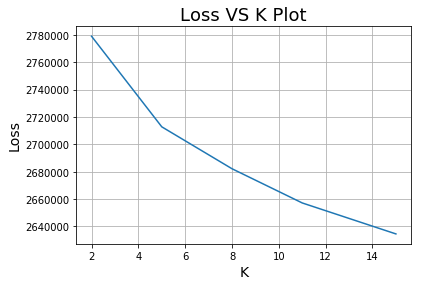

In [67]:
plt.plot(k_values, loss)
plt.xlabel('K',size=14)
plt.ylabel('Loss',size=14)
plt.title('Loss VS K Plot',size=18)
plt.grid()
plt.show()

In [87]:
bestN = 5

kmns = KMeans( n_clusters = bestN, random_state=42 )
kmns.fit( x_tr )

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [88]:
##https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
print( kmns.labels_.shape )
print( kmns.labels_[:50] )

(24000,)
[1 0 0 1 4 3 0 0 3 1 1 4 1 1 1 1 2 2 0 1 0 0 0 2 2 0 1 0 0 4 1 2 0 0 1 0 1
 4 1 3 0 0 0 3 1 4 0 1 0 0]


In [89]:
import numpy as np

clusterSet = { i: np.where( kmns.labels_ == i )[0] for i in range(bestN) }

clusterText = dict()

In [90]:
print( clusterSet[0].shape )
print( clusterSet[1].shape )
print( clusterSet[2].shape )
print( clusterSet[3].shape )
print( clusterSet[4].shape )

clusterSet[2]

(9168,)
(7132,)
(2930,)
(2413,)
(2357,)


array([   16,    17,    23, ..., 23989, 23993, 23998], dtype=int64)

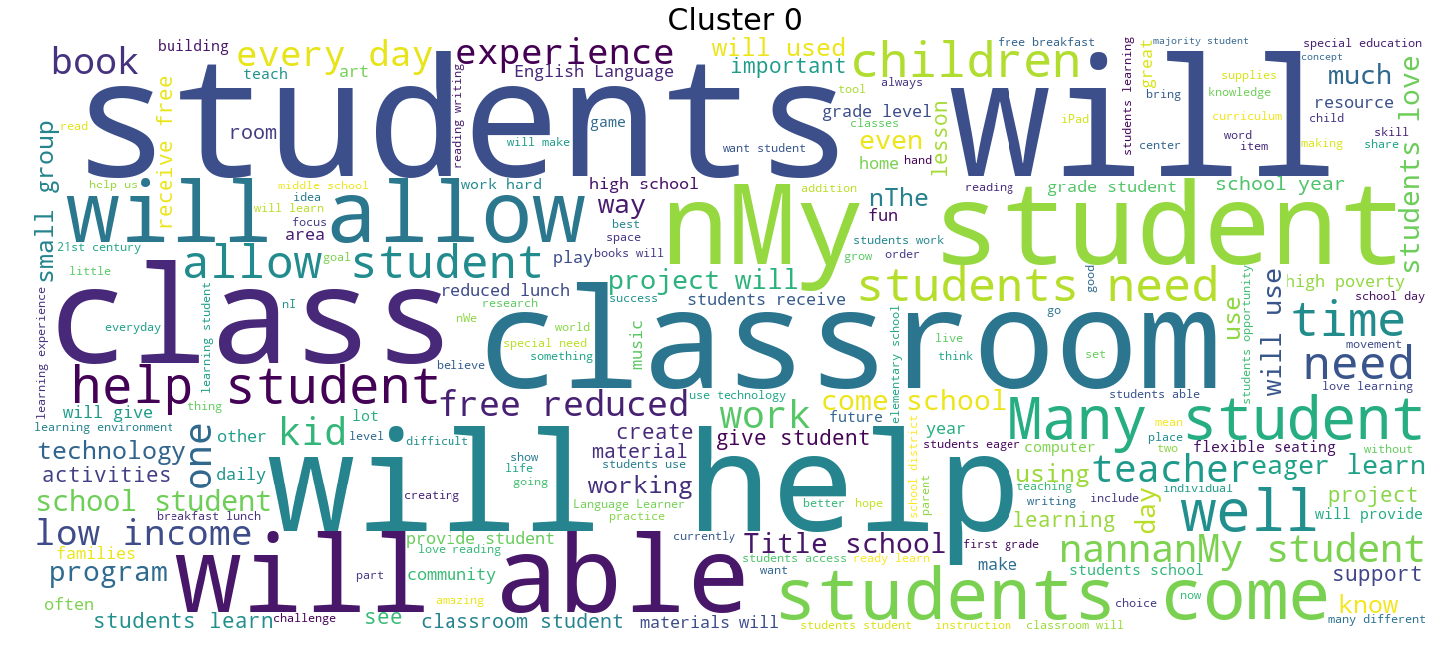

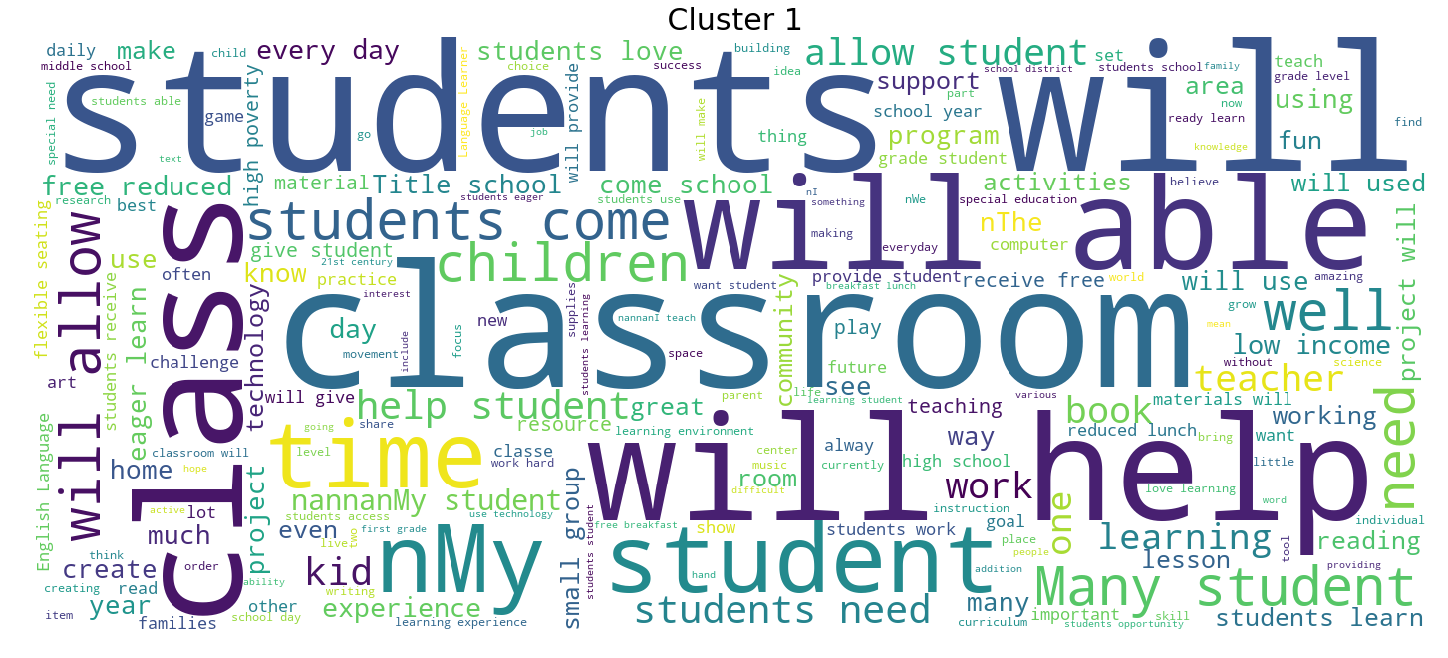

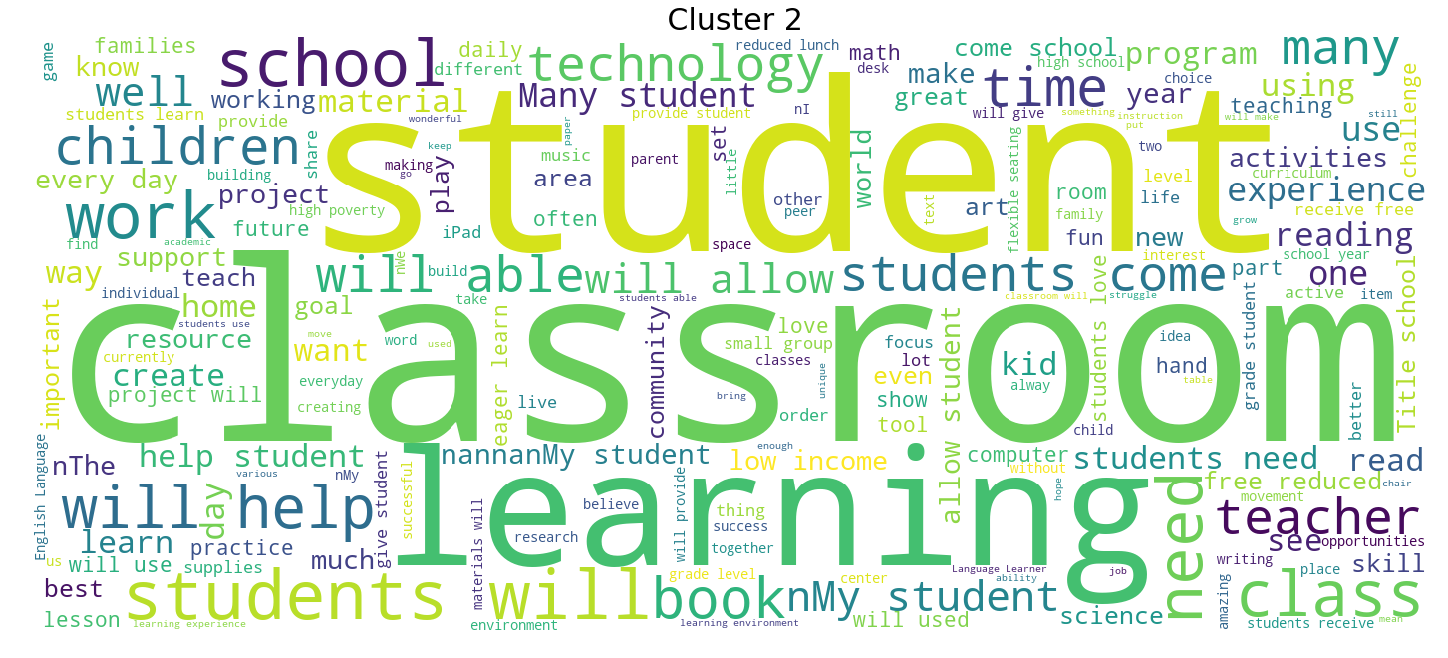

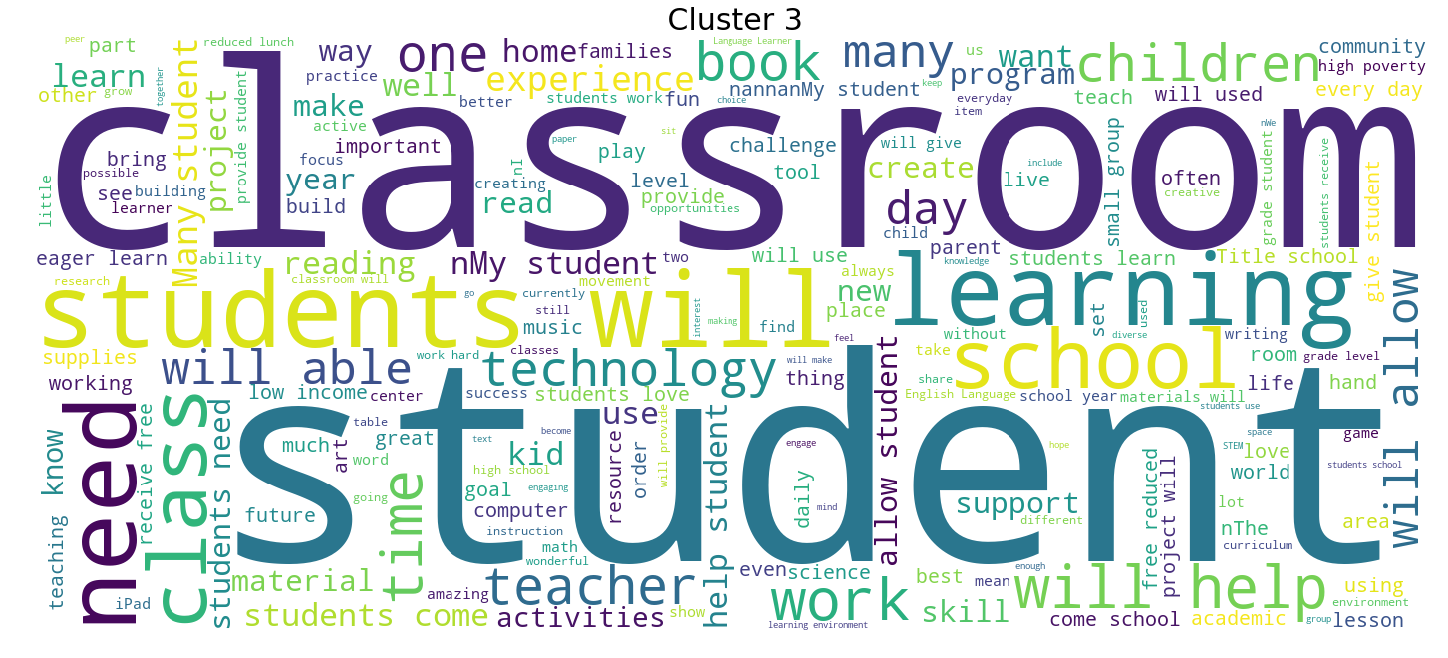

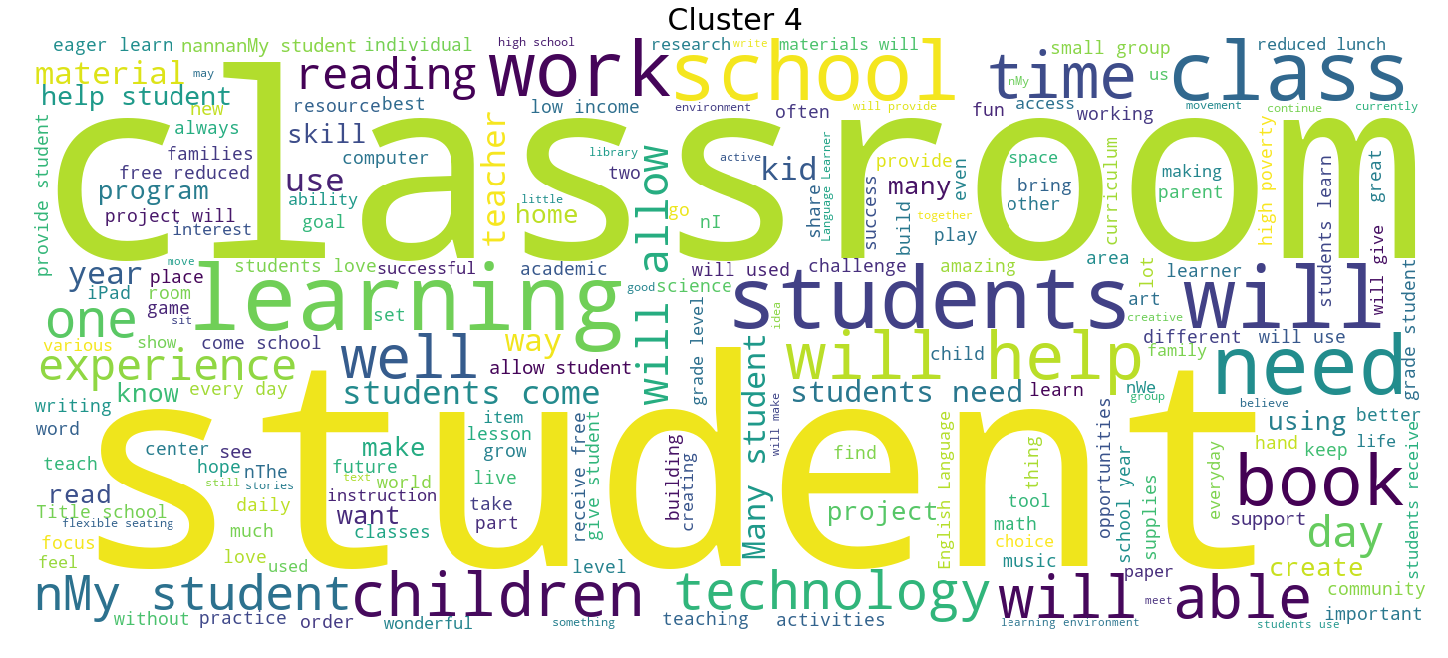

In [91]:
##https://www.geeksforgeeks.org/generating-word-cloud-python/
from wordcloud import WordCloud

for i in clusterSet:
    for j in clusterSet[i]:
        clusterText[i] = clusterText.get(i, '') + project_data.iloc[j]['essay']
        
for i in range( bestN ):
   
    # Create and generate a word cloud image:
    wordcloud = WordCloud( background_color='white', width=1400, height=600 ).generate( clusterText[i] )

    # Display the generated image:
    fig = plt.figure( figsize=(15,10) )
    plt.imshow( wordcloud )
    plt.title(f' Cluster {i}', size=30)
    plt.axis('off')
    plt.show()

plt.show()

### Agglomerative Clustering

In [66]:
x_train1=x_tr[:3000:]
x_test1=x_test[:3000]
print(x_train1.shape)
print(x_test1.shape)

(3000, 5000)
(3000, 5000)


#### For k=2

In [67]:
from sklearn.cluster import AgglomerativeClustering

aggcl=AgglomerativeClustering(n_clusters=2).fit(x_train1.toarray())

In [68]:
bestN=2
agg = AgglomerativeClustering( n_clusters= bestN )
agg.fit( x_train1.toarray() )

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=2,
            pooling_func='deprecated')

In [69]:
##https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
label = set(agg.labels_)
label

{0, 1}

In [70]:
clusterSet = { i: np.where( agg.labels_ == i )[0] for i in range(bestN)}
clusterText = dict()

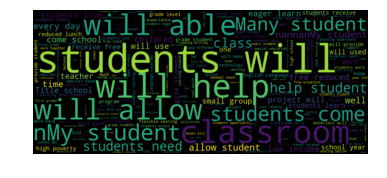

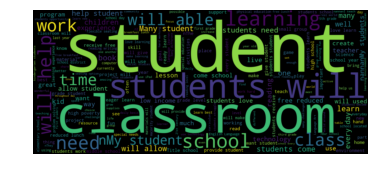

In [101]:
from wordcloud import WordCloud

for i in clusterSet:
    for j in clusterSet[i]:
        clusterText[i] = clusterText.get(i, '') + project_data.iloc[j]['essay']
        
for i in range( bestN ):
   
    # Create and generate a word cloud image:
    wordcloud = WordCloud( background_color='black', width=1400, height=600 ).generate( clusterText[i] )
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

plt.show()

### For K=5

In [102]:
from sklearn.cluster import AgglomerativeClustering

aggcl=AgglomerativeClustering(n_clusters=5).fit(x_train1.toarray())

In [103]:
bestN=5
agg = AgglomerativeClustering( n_clusters= bestN )
agg.fit( x_train1.toarray() )

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=5,
            pooling_func='deprecated')

In [104]:
label = set(agg.labels_)
label

{0, 1, 2, 3, 4}

In [105]:
clusterSet = { i: np.where( agg.labels_ == i )[0] for i in range(bestN)}
clusterText = dict()

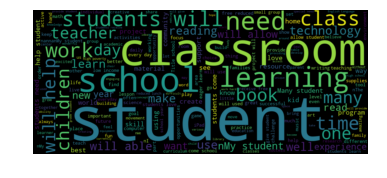

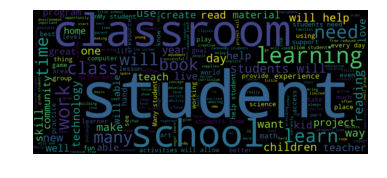

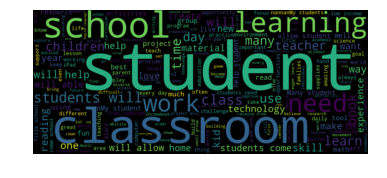

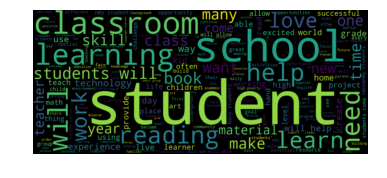

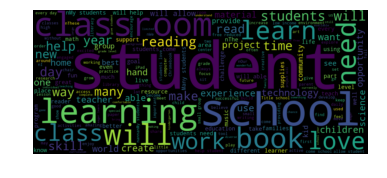

In [106]:
##https://www.geeksforgeeks.org/generating-word-cloud-python/
from wordcloud import WordCloud

for i in clusterSet:
    for j in clusterSet[i]:
        clusterText[i] = clusterText.get(i, '') + project_data.iloc[j]['essay']
        
for i in range( bestN ):
   
    # Create and generate a word cloud image:
    wordcloud = WordCloud( background_color='black', width=1400, height=600 ).generate( clusterText[i] )
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

plt.show()

### DBSCAN Clustering

In [92]:
x_train1=x_tr[:5000:].tocsr()
x_test1=x_test[:5000:].tocsr()
print(x_train1.shape)
print(x_test1.shape)

(5000, 5000)
(5000, 5000)


100%|██████████████████████████████████████| 5000/5000 [04:26<00:00, 18.77it/s]


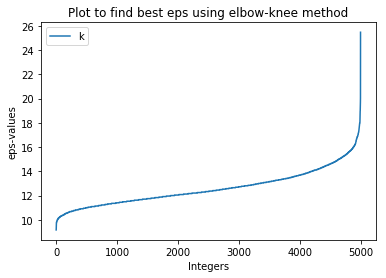

In [104]:
##https://stackoverflow.com/questions/48126771/nearest-neighbour-search-kdtree
from sklearn.neighbors import KDTree

algo_title = 'DBSCAN Clustering'
##https://stackoverflow.com/questions/12893492/choosing-eps-and-minpts-for-dbscan-r/48558030#48558030
minPts = 8
tree = KDTree(x_train1)

idx = 0
epss = []
for x_i in tqdm(x_train1):
    epss.append(tree.query(x_train1[idx].reshape(1,-1), return_distance=True, k=minPts)[0][0][-1])
    idx += 1
epss.sort()

plt.plot(range(0,5000), epss[:5000])
plt.title("Plot to find best eps using elbow-knee method")
plt.xlabel('Integers')
plt.ylabel('eps-values')
plt.legend('kneee')

In [106]:
##the best eps is 16 and am considering from the above plot

from sklearn.cluster import DBSCAN

db = DBSCAN( eps=16 )
db.fit( x_train1 )

DBSCAN(algorithm='auto', eps=16, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=5, n_jobs=None, p=None)

In [108]:
##https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
db.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [109]:
label = set(db.labels_)
label

{-1, 0}

In [110]:
clusterSet = { i: np.where( db.labels_ == i )[0] for i in range(-1,1)}
clusterText = dict()

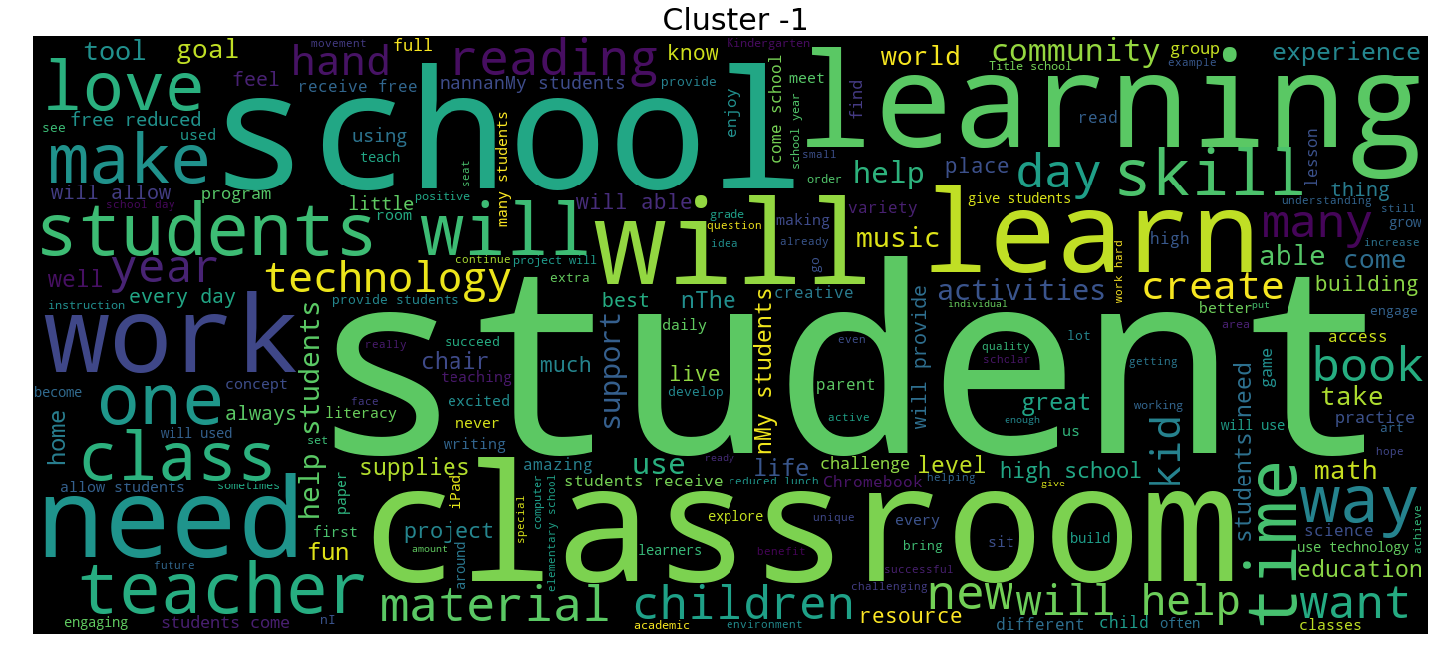

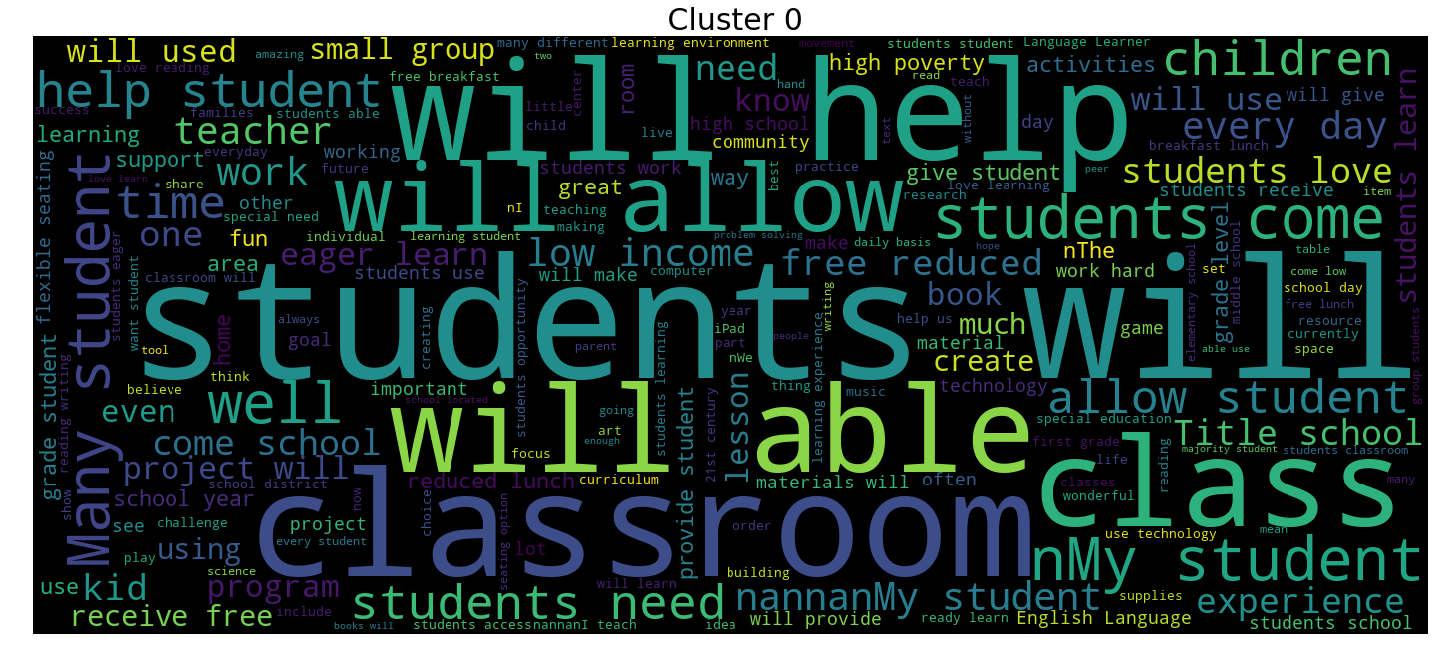

In [114]:
##https://www.geeksforgeeks.org/generating-word-cloud-python/

from wordcloud import WordCloud

for i in clusterSet:
    for j in clusterSet[i]:
        clusterText[i] = clusterText.get(i, '') + project_data.iloc[j]['essay']
        
for i in range( -1,1 ):
   
    # Create and generate a word cloud image:
    wordcloud = WordCloud( background_color='black', width=1400, height=600 ).generate( clusterText[i] )

    # Display the generated image:
    fig = plt.figure( figsize=(25,20) )
    plt.imshow( wordcloud )
    plt.title(f' Cluster {i}', size=30)
    plt.axis('off')
    plt.show()

plt.show()

### Summary

In [115]:
#http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
    
x = PrettyTable()
x.field_names = ["Vectorizer",  "Clustering",        "Hyperparameter" ]
x.add_row(["Bag of Words",   "K Means Clustering",    "n_clusters=5"])
x.add_row(["Bag of Words",   "Aglomerative",          " n_clusters=2 and  n_clusters=5"])
x.add_row(["Bag of Words",    "DBSCAN",               "eps = 16"])

print(x)

+--------------+--------------------+---------------------------------+
|  Vectorizer  |     Clustering     |          Hyperparameter         |
+--------------+--------------------+---------------------------------+
| Bag of Words | K Means Clustering |           n_clusters=5          |
| Bag of Words |    Aglomerative    |  n_clusters=2 and  n_clusters=5 |
| Bag of Words |       DBSCAN       |             eps = 16            |
+--------------+--------------------+---------------------------------+
